## DEV Bounding box augmentation for object detection ##

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from transformers import RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, yolo2xywh, clipxywh
from computervision.transformations import AugmentationTransform
from computervision.datasets import DETRdataset

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.2
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.environ.get('DATA')
print(f'data_dir: {data_dir}')
image_dir = os.path.join(data_dir, 'dentex_detection_250928')

data_dir: /app/data_model


## Load the annotations ##

In [3]:
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
parquet_file = os.path.join(image_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head(5))
print(f'Quadrants in data set: {sorted(list(df['quadrants'].unique()))}')

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,779,train_0_01.png,train_0,1,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,779,train_0_01.png,train_0,1,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,779,train_0_01.png,train_0,1,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,779,train_0_01.png,train_0,1,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,779,train_0_01.png,train_0,1,1,5,15,4,train


Quadrants in data set: [1, 2, 3, 4, 12, 14, 23, 34]


In [4]:
# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.

expected_images = len(df['file_name'].unique())
file_list = glob.glob(os.path.join(image_dir, '*.png'))
print(f'Found {len(file_list)} images in {image_dir}')
print(f'Expected number of images is {expected_images}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

Found 5065 images in /app/data_model/dentex_detection_250928
Expected number of images is 5065.


In [5]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Augmenting bounding boxes ###

In [6]:
im_size = 640
im_width = im_size
im_height = im_size

train_crop_transforms = [alb.RandomCropFromBorders(crop_left=0.3, 
                                                   crop_right=0.3, 
                                                   crop_top=0.5, 
                                                   crop_bottom=0.5, p=1.0),
                         alb.CenterCrop(height=im_height, width=im_width, pad_if_needed=True)]

train_image_transforms = [alb.Affine(scale=(0.8, 1.2), rotate=1, p=0.5),
                          alb.RandomBrightnessContrast(p=0.5),
                          alb.Sharpen(p=0.5),
                          alb.CLAHE(p=0.5)]

train_transforms = train_crop_transforms + train_image_transforms

# Validation transforms
val_crop_transforms = [alb.NoOp(p=1)]
val_image_transforms = [alb.AutoContrast(p=1), alb.CLAHE(p=1)]

val_transforms = val_crop_transforms + val_image_transforms

# Add the bounding box format to the dataset class
bbox_format = {'format': 'coco',
               'label_fields': ['tooth_position'],
               'clip': True,
               'min_area': 10000}

processor_params = {'do_resize': True,
                    'size': {'max_height': im_size,
                             'max_width': im_size},
                    'do_pad': True,
                    'pad_size': {'height': im_size,
                                 'width': im_size}}
# Image processor
model_checkpoint = 'PekingU/rtdetr_v2_r101vd'
image_processor = RTDetrImageProcessor.\
    from_pretrained(model_checkpoint, **processor_params)

In [7]:
print(*train_transforms, sep='\n')
print()
print(*val_transforms, sep='\n')

RandomCropFromBorders(p=1.0, crop_bottom=0.5, crop_left=0.3, crop_right=0.3, crop_top=0.5)
CenterCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, height=640, pad_if_needed=True, pad_position='center', width=640)
Affine(p=0.5, balanced_scale=False, border_mode=0, fill=0.0, fill_mask=0.0, fit_output=False, interpolation=1, keep_ratio=False, mask_interpolation=0, rotate=(1.0, 1.0), rotate_method='largest_box', scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)})
RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), ensure_safe_range=False)
Sharpen(p=0.5, alpha=(0.2, 0.5), kernel_size=5, lightness=(0.5, 1.0), method='kernel', sigma=1.0)
CLAHE(p=0.5, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

NoOp(p=1.0)
AutoContrast(p=1.0, cutoff=0.0, ignore=None, method='cdf')
CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


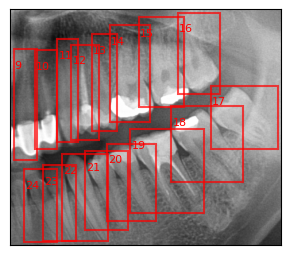

(701, 806, 3)
OUTPUT 1 / 10


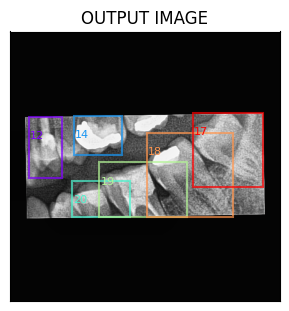

OUTPUT 2 / 10


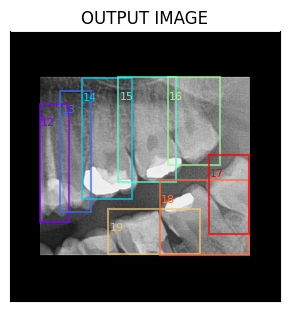

OUTPUT 3 / 10


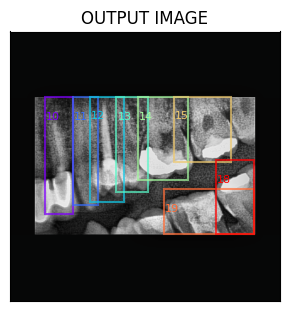

OUTPUT 4 / 10


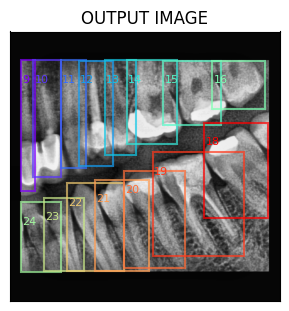

OUTPUT 5 / 10


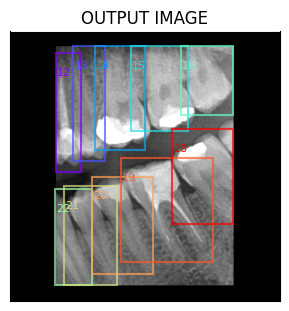

OUTPUT 6 / 10


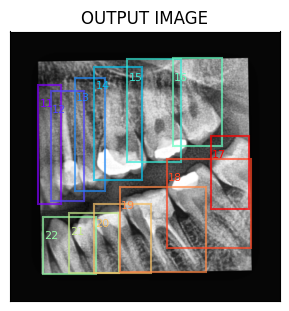

OUTPUT 7 / 10


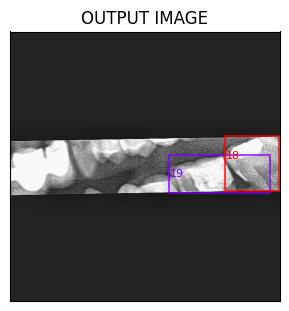

OUTPUT 8 / 10


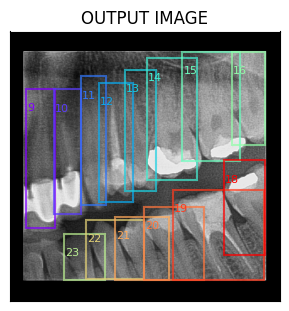

OUTPUT 9 / 10


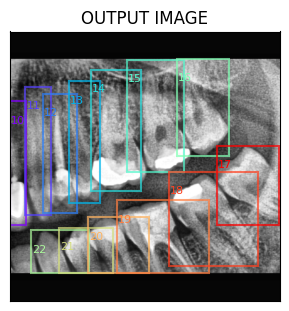

OUTPUT 10 / 10


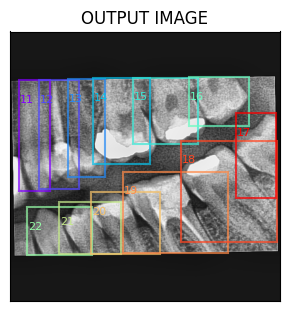

In [8]:
im_idx = 10
quadrants = 23
file_base_name = sorted(list(df['file_base_name'].unique()))[im_idx]
file_df = df.loc[
    (df['file_base_name']==file_base_name) & 
    (df['quadrants']==quadrants)]
file_name =  file_df['file_name'].tolist()[0]
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
bbox_list = file_df['bbox'].tolist()
label_list = file_df['ada'].tolist()

# Dataset
dataset = DETRdataset(data=file_df,
                      image_processor=image_processor,
                      image_dir=image_dir,
                      file_name_col='file_name',
                      label_id_col='ada',
                      bbox_col='bbox',
                      bbox_format=bbox_format,
                      transforms=train_transforms)
figsize = (3.5, 3.5)
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax, color='r')
plt.show()
print(im.shape)

n_outputs = 10
for n in range(n_outputs):
    print(f'OUTPUT {n + 1} / {n_outputs}')
    output = dataset[0]
    proc_image_tensor = output.get('pixel_values')
    proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))
    proc_annotation = output.get('labels')
    proc_size = list(proc_annotation.get('size').numpy().astype(int))
    proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
    proc_labels = list(proc_annotation.get('class_labels').numpy())
    proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())
    proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                                 image_width=proc_width, 
                                 image_height=proc_height) for yolobox in proc_boxes_yolo] 
    proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels)
    ax.set(title='OUTPUT IMAGE')
    plt.show()

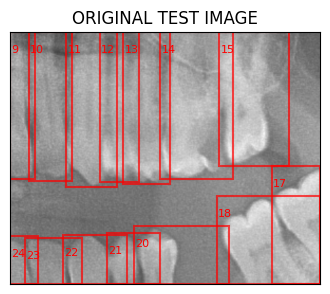

(478, 587, 3)
OUTPUT


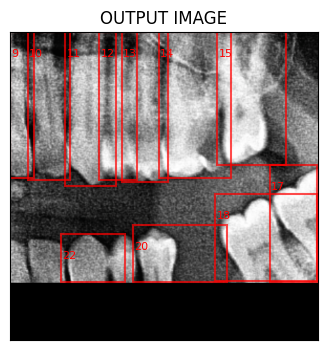

OUTPUT


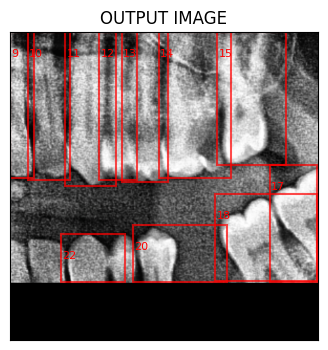

In [9]:
# The dentex test set
test_image_dir = os.path.join(image_dir, 'test')
im_idx = 12
parquet_file_name = 'train_quadrant_enumeration_test_set.parquet'
parquet_file = os.path.join(test_image_dir, parquet_file_name)
test_df = pd.read_parquet(parquet_file)
file_base_name = sorted(list(test_df['file_base_name'].unique()))[im_idx]
file_df = test_df.loc[
    (test_df['file_base_name']==file_base_name) & 
    (test_df['quadrants']==quadrants) &
    (test_df['transformation']==0)]
file_df = file_df.astype({'ada': int})
file_name =  file_df['file_name'].tolist()[0]
file = os.path.join(test_image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
bbox_list = file_df['bbox'].tolist()
label_list = file_df['ada'].tolist()

# Dataset
test_dataset = DETRdataset(data=file_df,
                           image_processor=image_processor,
                           image_dir=test_image_dir,
                           file_name_col='file_name',
                           label_id_col='ada',
                           bbox_col='bbox',
                           bbox_format=bbox_format,
                           transforms=val_transforms)
figsize = (4, 4)
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax, color='r')
ax.set(title='ORIGINAL TEST IMAGE')
plt.show()
print(im.shape)

for n in range(2):
    print(f'OUTPUT')
    output = test_dataset[0]
    proc_image_tensor = output.get('pixel_values')
    proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))
    proc_annotation = output.get('labels')
    proc_size = list(proc_annotation.get('size').numpy().astype(int))
    proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
    proc_labels = list(proc_annotation.get('class_labels').numpy())
    proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())
    proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                                 image_width=proc_width, 
                                 image_height=proc_height) for yolobox in proc_boxes_yolo] 
    proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels, color='r')
    ax.set(title='OUTPUT IMAGE')
    plt.show()

IMAGE 1 / 10



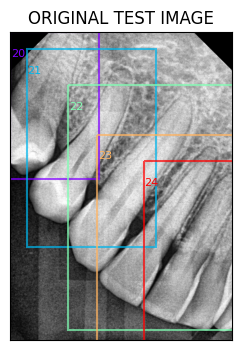

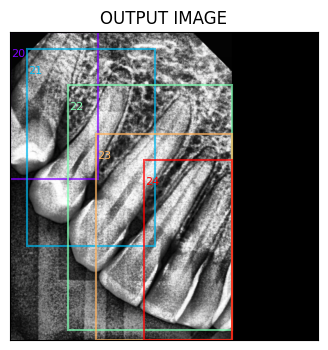

IMAGE 2 / 10



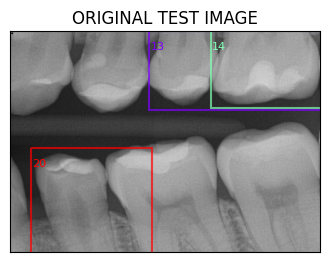

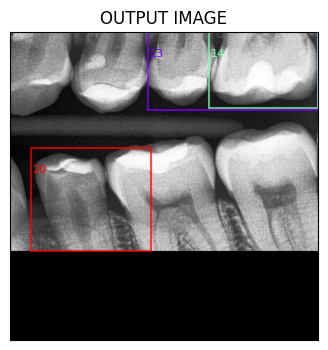

IMAGE 3 / 10



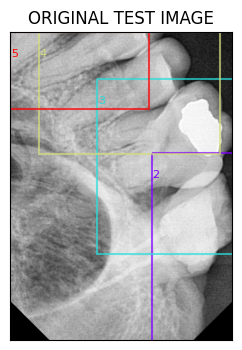

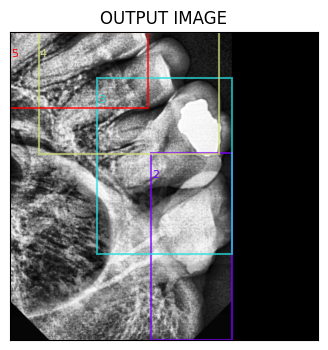

IMAGE 4 / 10



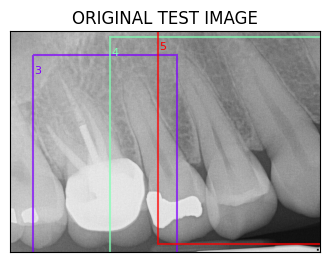

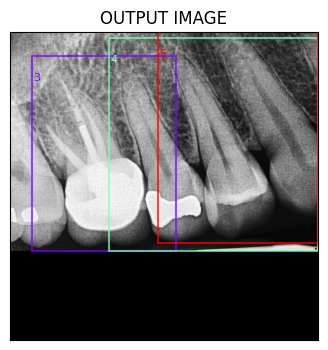

IMAGE 5 / 10



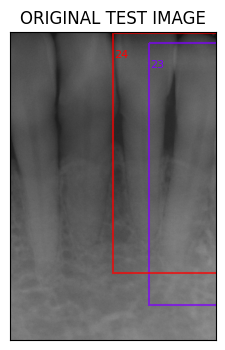

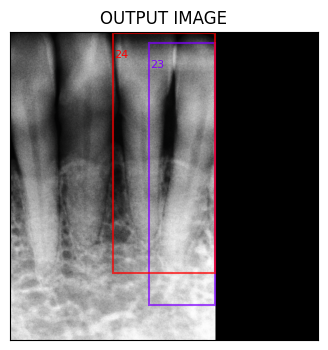

IMAGE 6 / 10



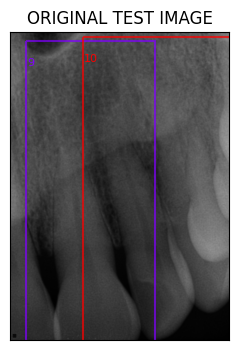

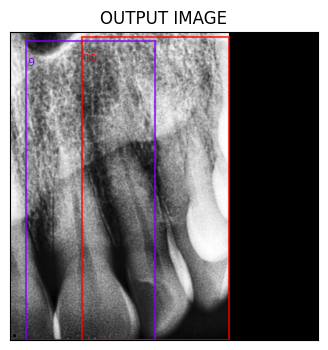

IMAGE 7 / 10



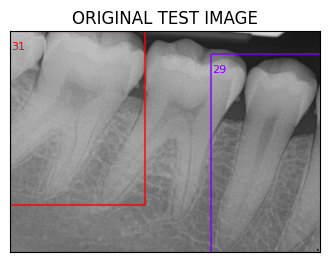

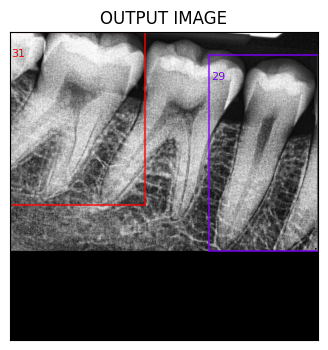

IMAGE 8 / 10



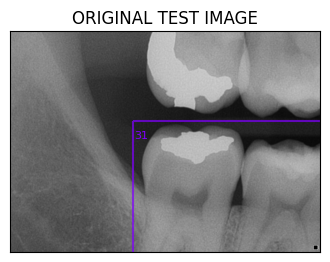

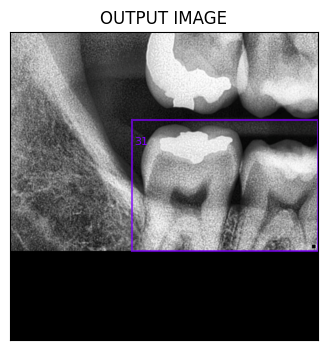

IMAGE 9 / 10



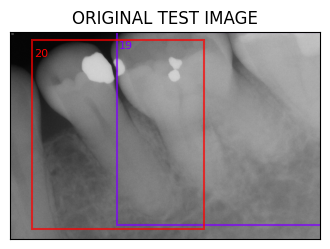

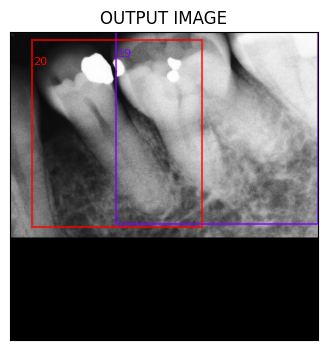

IMAGE 10 / 10



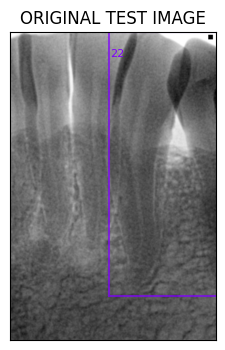

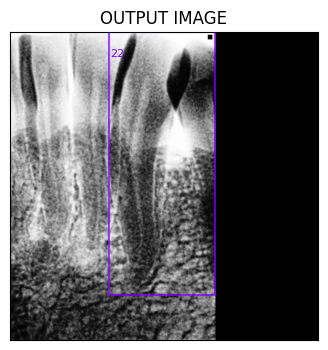

In [10]:
# Let's compare this with the input of the HMS test set
test_image_dir = os.path.join(data_dir, 'dataset_object_240921')
test_parquet_file_name = 'objectdata_240921_clean_ide.parquet'
test_parquet_file = os.path.join(test_image_dir, test_parquet_file_name)
test_df = pd.read_parquet(test_parquet_file)

seed_value = 42 
rng = np.random.default_rng(seed_value)
multi_file_list = sorted(list(test_df['multi_file'].unique()))
multi_file_list_choice = rng.choice(multi_file_list, size=10, replace=False)

for m, multi_file_name in enumerate(multi_file_list_choice):

    print(f'IMAGE {m + 1} / {len(multi_file_list_choice)}')
    print()
    
    test_file = os.path.join(test_image_dir, multi_file_name)
    test_file_df = test_df.loc[test_df['multi_file'] == multi_file_name]
    im = ImageData().load_image(test_file)
    im = ImageData().np2color(im)
    bbox_list = test_file_df['bbox'].tolist()
    label_list = test_file_df['pos'].tolist()
    
    # Dataset
    test_dataset = DETRdataset(data=test_file_df,
                               image_processor=image_processor,
                               image_dir=test_image_dir,
                               file_name_col='multi_file',
                               label_id_col='pos',
                               bbox_col='bbox',
                               bbox_format=bbox_format,
                               transforms=val_transforms)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax)
    ax.set(title='ORIGINAL TEST IMAGE')
    plt.show()

    # Show the output from the image processor
    output = test_dataset[0]
    proc_image_tensor = output.get('pixel_values')
    proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))
    proc_annotation = output.get('labels')
    proc_size = list(proc_annotation.get('size').numpy().astype(int))
    proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
    proc_labels = list(proc_annotation.get('class_labels').numpy())
    proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())
    proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                                 image_width=proc_width, 
                                 image_height=proc_height) for yolobox in proc_boxes_yolo] 
    proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels)
    ax.set(title='OUTPUT IMAGE')
    plt.show()